### Import packages 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np


## Define methods for later use

In [1]:
def make_splits(start, interval, time_before, time_after, measurements_count):
    splits = []
    if(measurements_count>0):
        splits.append((start - timedelta(seconds=time_before), start + timedelta(seconds=time_after)))
        splits.extend(make_splits(start + timedelta(seconds=interval),interval, time_before, time_after, measurements_count-1))
    return splits

def assign_range(times, splits):
    c_ix = 0
    in_split = False
    ranges = []
    for index, time in times.iteritems():
        if(splits[c_ix][0] <= time <= splits[c_ix][1]):
            in_split = True
        elif(in_split == True):
            if(c_ix +1 < len(splits)):
                c_ix += 1
            in_split = False

        if(in_split):
            ranges.append(str(splits[c_ix]))
        else:
            ranges.append(None)
    ranges = np.array(ranges)
    return ranges

def window_rms(a, window_size):
    a2 = np.power(a,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(a2, window, 'valid'))

## Define variables

In [3]:
recordings_file = './Recordings/15. January/Algus_17.19.40.txt'
target_file = ''

start_datetime = datetime(year=2020, month=1, day=15, hour=17, minute=19, second=40)
interval = 10
time_before = 1
time_after = 3
measurements_count = 48

## Import data

In [4]:
data = pd.read_csv(recordings_file, skiprows=6, delimiter=",", names=np.arange(13))
data = data.reset_index()
data['datetime'] = data[12].apply(lambda x: datetime.fromtimestamp(x/1000.0))
data = data[[2,3,5,'datetime']]
data.columns = ["unrailed","brow", "cheek", "datetime"]
data.head()

,unrailed,brow,cheek,datetime
0,0.0,0.00,0.00,2020-01-15 17:16:44.001
1,187500.0,-15598.25,22661.74,2020-01-15 17:16:44.017
2,187500.0,-15599.93,22668.74,2020-01-15 17:16:44.022
3,187500.0,-15599.73,22677.54,2020-01-15 17:16:44.024
4,187500.0,-15602.17,22672.80,2020-01-15 17:16:44.029


### Define splits of measurements

In [5]:
### Assign timestamps into ranges
splits = make_splits(start_datetime, interval, time_before, time_after, measurements_count)
splits[:5]
data['ranges'] = assign_range(data['datetime'], splits)

## Data visualization

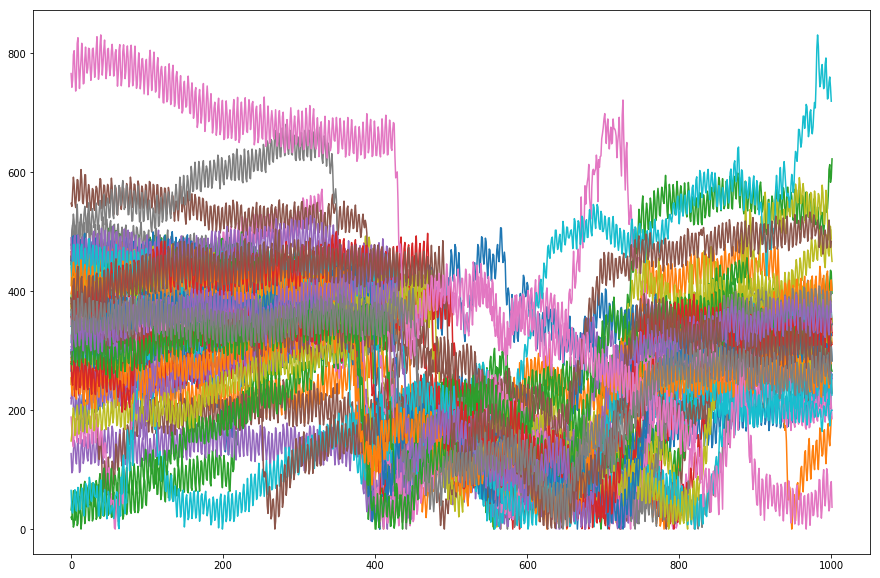

In [6]:
fig,ax = plt.subplots(figsize=(15,10))

groups = data.groupby('ranges')
for group in groups.groups:
    df = groups.get_group(group)
    line = df['cheek'].values
    line -= line.min()
    ax.plot(line)
    
plt.show()

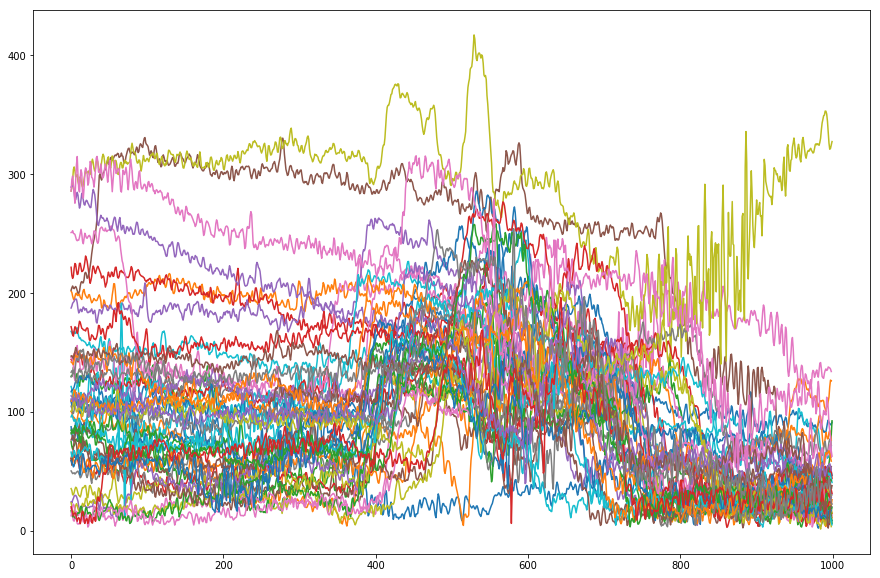

In [95]:
fig,ax = plt.subplots(figsize=(15,10))

groups = data.groupby('ranges')
for group in groups.groups:
    df = groups.get_group(group)
    line = df['brow'].values
    line -= line.min()
#     ax.plot(line)
    ax.plot(window_rms(line,3))
plt.show()

In [96]:
with open('./Recordings/15. January/Algus_17.19.40_action.txt', 'r') as file:
    lines = file.readlines()[1:]    

lines = np.array([line.replace("\n","") for line in lines])
lines = lines == 'T'
lines.shape

y = lines

## RMS on windows for signal shooting

In [102]:
window_size = 15

groups = data.groupby('ranges')
groups_min = groups.size().min()
groups_min
cheek_array = groups['brow'].apply(lambda x: x.head(groups_min)).values
cheek_array = cheek_array.reshape(len(groups), groups_min)


cheek_array_rms = np.array([window_rms(ar,window_size) for ar in cheek_array])
cheek_array_rms.shape

(48, 987)

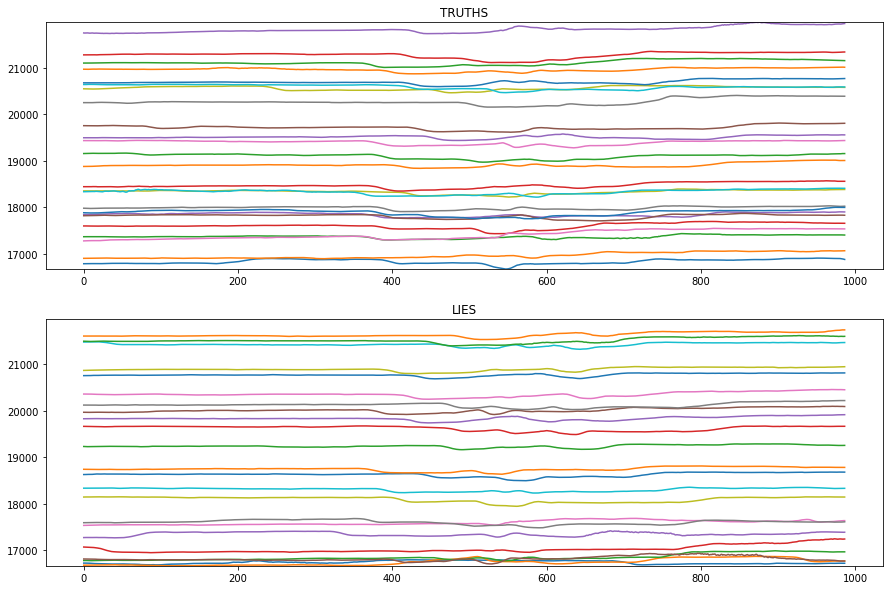

In [103]:
fig, axes = plt.subplots(2,1, figsize=(15,10))


for ar in cheek_array_rms[lines,:]:
    axes[0].plot(ar)

for ar in cheek_array_rms[~lines,:]:
    axes[1].plot(ar)
    
axes[0].set_title("TRUTHS")
axes[1].set_title("LIES")
    
for ax in axes:
    ax.set_ylim(cheek_array_rms.min(), cheek_array_rms.max())
    

# Classification

In [104]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cheek_array_rms, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train,y_train)


GaussianNB(priors=None, var_smoothing=1e-09)

# Evaluation

In [105]:
from sklearn.metrics import accuracy_score

accuracy_score(gnb.predict(X_test), y_test), accuracy_score(gnb.predict(X_train), y_train)

(0.4, 0.5)